In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import os
import numpy as np
from os import listdir
from pathlib import Path
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import h5py
import pydicom as dicom
import matplotlib.pyplot as plt
from dicompylercore import dicomparser, dvh, dvhcalc
from dicom_contour.contour import get_contour_file,get_roi_names, coord2pixels, cfile2pixels, plot2dcontour, slice_order, get_contour_dict, get_data,  create_image_mask_files
from preprocessing.get_plan_from_dicom import Plan
from dicom_contour.contour import get_ct_name_dict
from dicom_contour.dose import build_dose_volume

In [2]:
path = './dicom_data/TMI_Chavez/'

In [4]:
plan = Plan()
plan.get_plan_mask(path)

KeyboardInterrupt: 

np.shape(structures['image'])

In [ ]:
RS_mask['image'].shape

In [19]:
rtdose = dicomparser.DicomParser("RD_test.dcm")
heartdvh = dvh.DVH.from_dicom_dvh(rtdose.ds, 8)

<IPython.core.display.Javascript object>


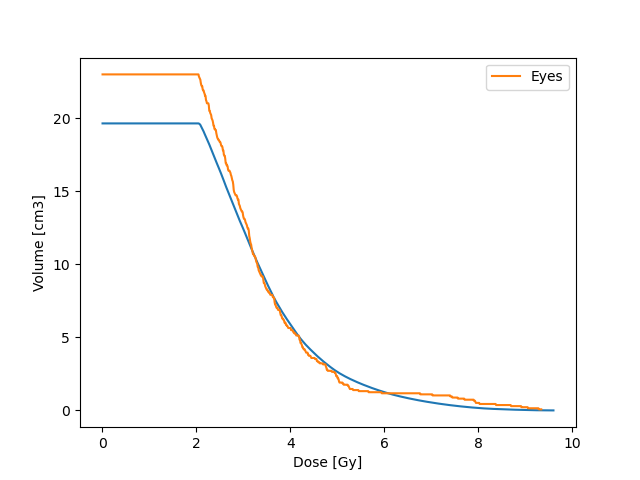

DVH(cumulative, 960 bins: [0.0:9.59999999999984] Gy, volume: 19.6434179925105 cm3, name: None, rx_dose: 0 Gy)

In [27]:
heartdvh.plot()

In [21]:
calcdvh = dvhcalc.get_dvh("RS_test.dcm", "RD_test.dcm", 8)

In [28]:
calcdvh.plot()

DVH(cumulative, 934 bins: [0.0:9.34] Gy, volume: 22.998047560394795 cm3, name: 'Eyes', rx_dose: 0 Gy)

In [27]:
f = dicom.dcmread('CT_test.dcm')

In [28]:
f.Modality

'CT'

In [54]:
x=np.array([1,2,3])
y=np.array([4,5,6])
z = np.array([7])
xx,yy, zz = np.meshgrid(x,y,z)

In [65]:
dose_plane = dose_vol.interpolating_function(test)

In [64]:
test = np.dstack((xx,yy,zz))

In [63]:
test[0,1,:]

array([2, 4, 7])

In [67]:
np.shape(dose_plane)

(3, 3)